In [108]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [109]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [110]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 0

In [111]:
import utils

data_dict = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)

In [112]:
data_dict.keys()

dict_keys(['network', 'fmin', 'fmax', 'length', 'sweep', 'port_pairs'])

## Pre-process the data

In [113]:
data_net = data_dict['network']
data_freqs = data_dict['network'].frequency

In [114]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 1000
Spacing: 2.0000e+07
Start: 2.0000e+07
Stop: 2.0000e+10


In [115]:
f_start = data_freqs.start
f_step = data_freqs.step
good_spacing = (f_start / f_step).is_integer()
print("Can extrapolate without aliasing: ", good_spacing)

spacing = data_dict["sweep"]
print("SPACING: ", spacing)

good_chip = good_spacing and (spacing == "LINEAR")
print("GOOD SPACING!!!" if good_chip else "BAD SPACING???")

Can extrapolate without aliasing:  True
SPACING:  LINEAR
GOOD SPACING!!!


In [116]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['2.0000e+07', '4.0000e+07', '6.0000e+07', '8.0000e+07', '1.0000e+08']


In [117]:
data_net = data_net.extrapolate_to_dc()
data_freqs = data_net.frequency 

In [118]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 1001
Spacing: 2.0000e+07
Start: 0.0000e+00
Stop: 2.0000e+10


In [119]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['0.0000e+00', '2.0000e+07', '4.0000e+07', '6.0000e+07', '8.0000e+07']


## Check the causality of the extrpolated Signal

In [120]:
out_matrix_re = data_net.s.real
out_matrix_im = data_net.s.imag
out_matrix = np.stack((out_matrix_re, out_matrix_im), axis=-1)

out_sparams = utils.matrix_to_sparams(out_matrix)

out_sparams = torch.from_numpy(out_sparams)

In [121]:
print(out_sparams.shape)

torch.Size([3, 2, 1001])


In [122]:
complex_sparams = torch.complex(out_sparams[:, 0, :], out_sparams[:, 1, :])

In [124]:
print(complex_sparams.shape)

torch.Size([3, 1001])


In [125]:
real_ifft = torch.fft.irfft(complex_sparams, n=(2*complex_sparams.shape[-1] - 1))

In [126]:
print(real_ifft.shape)

torch.Size([3, 2001])


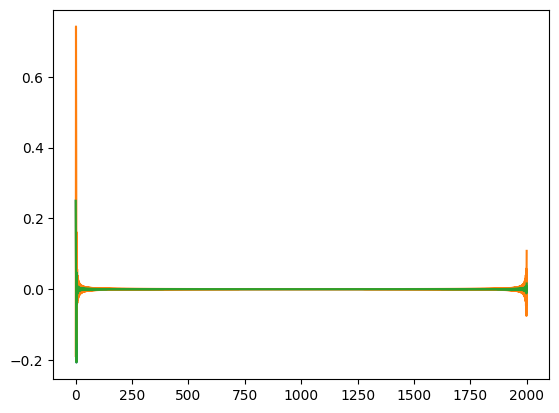

In [127]:
plt.figure()
for i in range(real_ifft.shape[0]):
    plt.plot(real_ifft[i, :], label=str(i))
plt.show()

In [128]:
real_ifft[:, data_freqs.npoints+1:] = 0*real_ifft[:, data_freqs.npoints+1:]

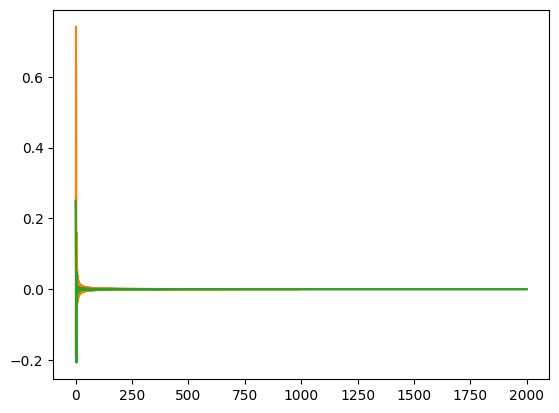

In [129]:
plt.figure()
for i in range(real_ifft.shape[0]):
    plt.plot(real_ifft[i, :], label=str(i))
plt.show()

In [130]:
zerod_fft = torch.fft.rfft(real_ifft)
print(zerod_fft.shape)

torch.Size([3, 1001])


In [131]:
zerod_sparams = torch.stack([zerod_fft.real, zerod_fft.imag], dim=1)
print(zerod_sparams.shape)

torch.Size([3, 2, 1001])


In [132]:
torch.mean((zerod_sparams - out_sparams)**2)

tensor(0.0059)

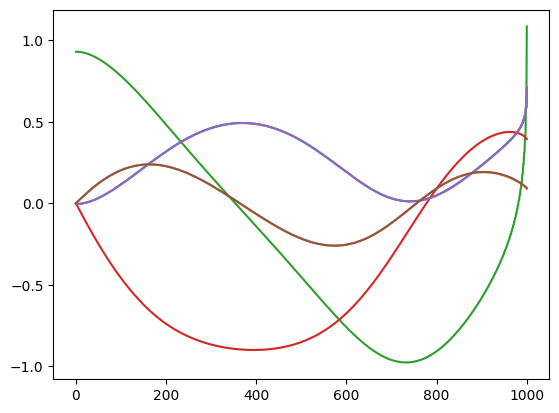

In [133]:
plt.figure()
for i in range(zerod_sparams.shape[0]):
    plt.plot(zerod_sparams[i, 0, :])
    plt.plot(zerod_sparams[i, 1, :])
plt.show()

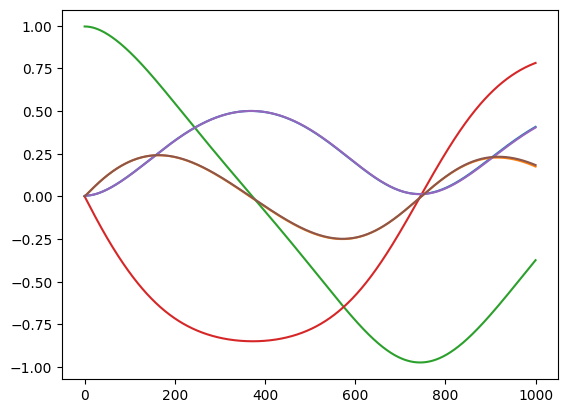

In [134]:
plt.figure()
for i in range(out_sparams.shape[0]):
    plt.plot(out_sparams[i, 0, :])
    plt.plot(out_sparams[i, 1, :])
plt.show()

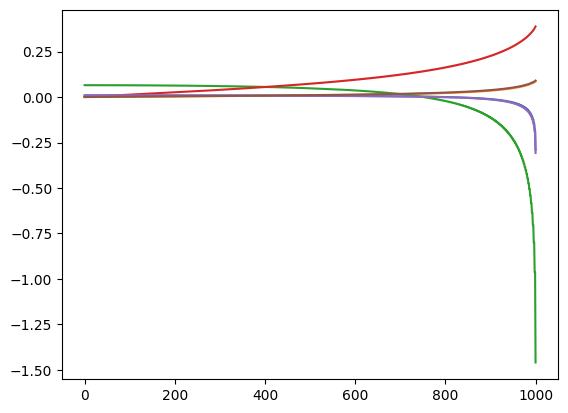

In [135]:
diff_sparams = out_sparams - zerod_sparams

plt.figure()
for i in range(diff_sparams.shape[0]):
    plt.plot(diff_sparams[i, 0, :])
    plt.plot(diff_sparams[i, 1, :])
plt.show()

## Make some variables we will need

In [ ]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

In [ ]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

In [ ]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

## Grab Some Measurements

In [ ]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
M = 0.1

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

In [ ]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

In [ ]:
y_mag = utils.sparams_to_mag(y)

print("x_mag shape: ", y_mag.shape)

In [ ]:
z = torch.clone(x)
z[:, :, missing_inds] = 0

print("z shape: ", z.shape)

## Plot data and measurements

In [ ]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

In [ ]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

In [ ]:
@torch.no_grad()
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

x_diff_2 = calc_diffs(x, 3)

print(x_diff_2.shape)

plt.figure()
for i in range(x_diff_2.shape[1]//2):
    plt.plot(x_diff_2[0,2*i,:].squeeze().cpu(), label=str(i)+" Re")
    plt.plot(x_diff_2[0,2*i+1,:].squeeze().cpu(), label=str(i)+" Im")
plt.title("Third-Order Diffs")
plt.show()

# 2. Network Setup

## Define network parameters

In [ ]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NC = y.shape[1]

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

In [ ]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)

## Init and check dimensions

In [ ]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [ ]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

# Define Running Functions and Stuff

In [ ]:
LR = 2e-4 
NUM_ITER = 10000 

REG_HYPERPARAM = 1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 2
REG_NORM = 2

# REG_HYPERPARAM = 1e-2
# REG_TYPE = "wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

# REG_HYPERPARAM = 1e-5
# REG_TYPE = "centered_wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

REDUCTION = "mean"

In [ ]:
START_NOISE_LEVEL = 1
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

# START_NOISE_LEVEL = None
# NOISE_DECAY_FACTOR = None

In [ ]:
# SGLD = False
# BURN_IN_ITER = 5000
# SAVE_OUTPUT_EVERY = 1

SGLD = True
BURN_IN_ITER = 5000
SAVE_OUTPUT_EVERY = 100

In [ ]:
import Fitting

dip_args = {"y": y,
            "x": x,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": kept_inds,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [ ]:
dip_results = Fitting.run_dip(dip_args)

In [ ]:
print("Final MSE: ", dip_results.mse_list_gt[-1])
print("Final Mean MSE: ", dip_results.mse_list_mean_gt[-1])

In [ ]:
MAX_IDX = 100

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.show()

In [ ]:
out_mag_list = [utils.sparams_to_mag(i) for i in dip_results.out_list]

mean_out_mag = torch.mean(torch.cat(out_mag_list), dim=0, keepdim=True)
std_out_mag = torch.std(torch.cat(out_mag_list), dim=0, keepdim=True)

In [ ]:
last_out = dip_results.out_list[-1]

last_out_mag = utils.sparams_to_mag(last_out)

In [ ]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

In [ ]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,8))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, std_out_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,8))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, resid_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,8))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, mean_out_mag[0,i][kept_inds].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")